# Notebook Dedicated to Re-scale the Number of Simulated Reactor Antinu Events to the number of Events Expected in the Livetime of the Real Data set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from scipy.special import factorial
from lmfit import Model
from scipy.optimize import curve_fit

import pandas as pd

import glob

# Load Data

Lets read the data as follows:
1) Create a list of the main folders output_0, output_1, ...
2) Create a list with the file names of the observables to be readen
3) Take the ith diretory of the list of main folders, and join it to the observable name list to be readen and save the observables values for each iteration over output_i folders

In [2]:
# ======= Cuts on Data Observables =======
energy_prompt_sup_cut = 8

energy_delay_sup_cut = 2.3
energy_delay_inf_cut = 1.9

dt_sup_lim = 1000
dt_inf_lim = 0.5

dr_sup_lim = 900
# ========================================

#Main Data Directory
main_dir = 'E:/Data/antinu/mc/reactor_nu/out_results/'
folder_name_pattern = 'output_*/'

main_dir_list = glob.glob(main_dir + folder_name_pattern)
main_dir_list

#Observable file names to be readen
obs_real_list = ['dt', 'dr', 'energy_prompt', 'energy_delay']

#Dictionary with empty np.arrays of the observables to be readen
observable_dict = {obs_i : np.array([]) for obs_i in obs_real_list}

#Iteration over main directory list
for main_dir_list_i in main_dir_list:
    print(f'reading folder {main_dir_list_i}')
    #Create the directories for the observables (defined along the next iteration) to be readen using the main_dir_list_i and save its value
    for obs_i in obs_real_list:
        print(f'saving information of observable {obs_i}')
        dir_obs_i = main_dir_list_i + obs_i + '.npy'  #Create the full directory of the observable 
        array_obs_i = np.load(dir_obs_i)              #Load the numpy array of the corresponding observable obs_i
        observable_dict[str(obs_i)] = np.append(observable_dict[str(obs_i)], array_obs_i)  #Save the observable in the dictionary


#Define energy cut on prompt and delay to plot. In the MC data is seen how there are energy values higher than 8 MeV
#Extract energy arrays to perform cuts
energy_prompt = observable_dict['energy_prompt']
energy_delay = observable_dict['energy_delay'] #Limit energy delay, but this is strange to be larger ...
dt = observable_dict['dt']
dr = observable_dict['dr']

cut_condition = (energy_prompt <= energy_prompt_sup_cut) & (energy_delay <= energy_delay_sup_cut) & (energy_delay >= energy_delay_inf_cut) & (dt > dt_inf_lim) & (dt <= dt_sup_lim) & (dr <= dr_sup_lim)

energy_prompt = energy_prompt[cut_condition]
energy_delay = energy_delay[cut_condition]
dt = dt[cut_condition]
dr = dr[cut_condition]

reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_0\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_1\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_10\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_11\
saving information of observable dt
saving information of observable dr
saving information of observable energy_prompt
saving information of observable energy_delay
reading folder E:/Data/antinu/mc/reactor_nu/out_results\output_12\
saving 

# Scale the Number of Events

## Nº of Events Calculation

In [3]:
# ======= Livetime Values =======
N_exp_ev_per_day = 35.8/134.4  # Nº of expected reactor antinu events per day

dataset_tot_lf = 228.04 # Nº of Days of the raw real dataset (only cuts on scintfit, fitvalid, dcflag, nhits and E_min)
cut_time = 29.43 # Nº of days to be removed from the dataset_tot_lf due to run cuts, hotsposts and atmospherics

total_lf = dataset_tot_lf - cut_time  # Total livetime of the raw dataset

N_mc_ev = len(energy_prompt) # Number of coincidence MC events
N_scaled_mc_ev = total_lf * N_exp_ev_per_day # Nº of expected reactor antinu events during the total livetime of the real Dataset
scale_factor = N_scaled_mc_ev / N_mc_ev  #Factor to be use as weight to represente MC histogram vs. real data histograms
N_scaled_mc_ev

52.90355654761903

## MC Events Selection

Now the idea is to select N_scaled_mc_ev events in order to directly compare with the real data analysis results. The next steps must be followed:
1) Define the number of events we want to pick from the MC data;
2) Arange the data by ([energy_prompt, energy_delay], dt, dr)
3) Select events randomly and uniformly;

In [12]:
N_mc_ev = len(energy_prompt) # Number of MC events
rng = np.random.default_rng(seed=123456)  # Create a seed generator to reproduce the random choice

# Create random indices and pick the MC events
indices = rng.choice(N_mc_ev, size = int(N_scaled_mc_ev), replace = False)

energy_prompt_scaled = energy_prompt[indices]
energy_delay_scaled  = energy_delay[indices]
dr_scaled            = dr[indices]
dt_scaled            = dt[indices]

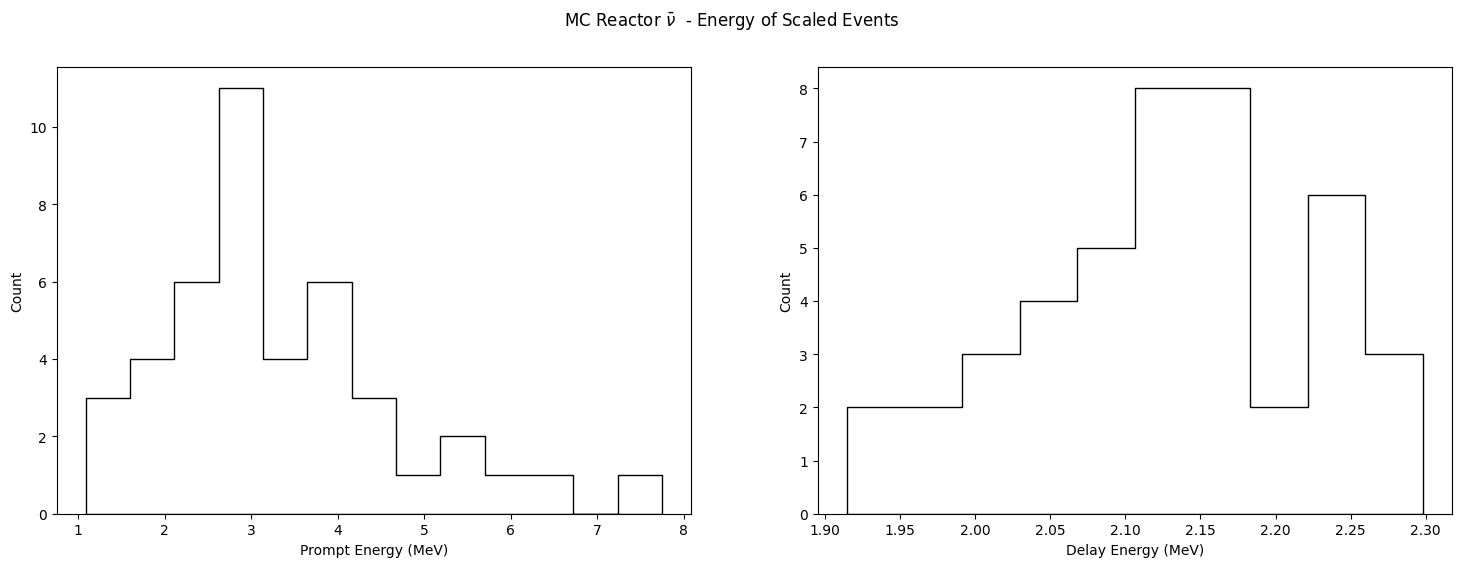

In [13]:
binwidth_prompt = 0.5
binwidth_delay = 0.04

fig, axes = plt.subplots(1, 2,  figsize=(18, 5.8))

sn.histplot(energy_prompt_scaled, ax = axes[0],  binwidth = binwidth_prompt, color = 'black', element = 'step', alpha = 0)
sn.histplot(energy_delay_scaled, ax = axes[1], binwidth = binwidth_delay, color = 'black', element = 'step', alpha = 0)

axes[0].set_xlabel('Prompt Energy (MeV)')
#axes[0].set_yscale('log')

axes[1].set_xlabel('Delay Energy (MeV)')
#axes[1].set_yscale('log')

plt.suptitle(r"MC Reactor $\bar{\nu}$  - Energy of Scaled Events", fontsize = 12)
#plt.savefig(save_dir + 'prompt and delay energy/energy_' + main_title_save+'.png', format = 'png', bbox_inches = 'tight')

plt.show()

In [6]:
np.ravel(energy_prompt)


array([2.08581803, 3.99724254, 3.8243975 , ..., 1.76328655, 3.98027517,
       3.38283677])

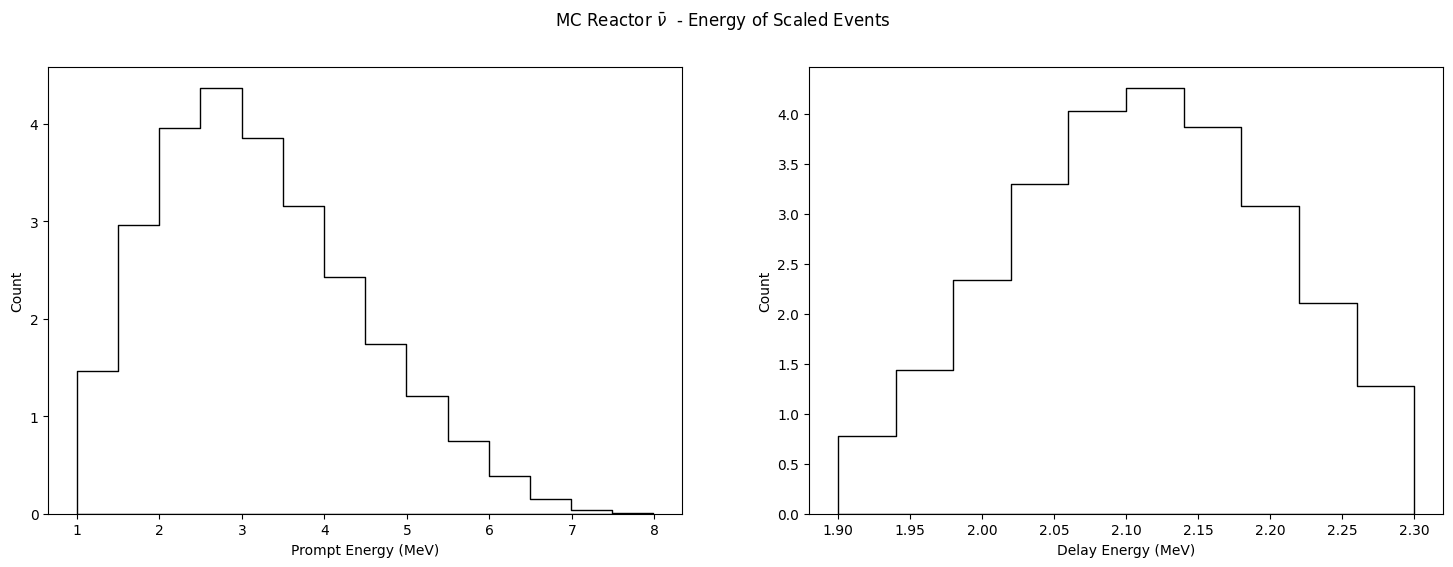

In [8]:
binwidth_prompt = 0.5
binwidth_delay = 0.04

fig, axes = plt.subplots(1, 2,  figsize=(18, 5.8))

sn.histplot(x = energy_prompt.flatten(), weights = np.ones(len(energy_prompt))*scale_factor/2, ax = axes[0], binwidth = binwidth_prompt, color = 'black', element = 'step', alpha = 0)
sn.histplot(x = energy_delay.flatten(), weights = np.ones(len(energy_delay))*scale_factor/2, ax = axes[1], binwidth = binwidth_delay, color = 'black', element = 'step', alpha = 0)

axes[0].set_xlabel('Prompt Energy (MeV)')
#axes[0].set_yscale('log')

axes[1].set_xlabel('Delay Energy (MeV)')
#axes[1].set_yscale('log')

plt.suptitle(r"MC Reactor $\bar{\nu}$  - Energy of Scaled Events", fontsize = 12)
#plt.savefig(save_dir + 'prompt and delay energy/energy_' + main_title_save+'.png', format = 'png', bbox_inches = 'tight')

plt.show()